In [1]:
import requests
from datetime import datetime

import os
from apiclient.http import MediaFileUpload, MediaIoBaseDownload
from google.oauth2 import service_account
from googleapiclient.discovery import build

def setup_gdrive(credentials_secret):
    with open('credentials.json', 'w') as f:
        f.write(os.environ[credentials_secret])
        
    # Load the credentials from the JSON key file
    credentials = service_account.Credentials.from_service_account_file(
        'credentials.json',
        scopes=['https://www.googleapis.com/auth/drive']
    )

    drive_service = build('drive', 'v3', credentials=credentials)
    return drive_service



In [5]:
with open('enre-414003-3724f64a117f.json') as f:
    credentials = f.read()

os.environ['GDRIVE_SECRET'] = credentials

In [8]:
drive_service = setup_gdrive('GDRIVE_SECRET')

In [22]:
import os

def download_file(file, path, skip_existing=False):
    file_id = file['id']
    request = drive_service.files().get_media(fileId=file_id)
    if skip_existing and os.path.exists(os.path.join(path, file['name'])):
#         print('\t skipping')
        return
    
    with open(os.path.join(path, file['name']), 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
#             print(f"Download {int(status.progress() * 100)}%. {file_id}")

In [23]:
def download_all_files(path, skip_existing):
    response = drive_service.files().list().execute()
    
    files = response['files']
    page_no = 1
    while response.get('nextPageToken'):
        print('Downloading page', page_no)
        for file in files:
            download_file(file, path, skip_existing=skip_existing)
        
        response = drive_service.files().list(pageToken=response['nextPageToken']).execute()
        files = response['files']
        page_no += 1
    print('Finished Downloading')

In [ ]:
import os

if not os.path.exists('data'): os.makedirs('data')
    
download_all_files('data', skip_existing=True)

In [27]:
import json
import re
import os

def parse_fname_date(fname):
    date_pat = re.compile('(\d{4}-\d{2}-\d{2}T\d{2})')
    return datetime.strptime(date_pat.search(fname).group(0), '%Y-%m-%dT%H')

def parse_cortes(fname):
    """
    convierte el json crudo de cortes en una lista de diccionarios (tambien parsea la descripccion)
    """
    open_func = gzip.open if fname.endswith('gz') else open
    with open_func(fname) as f:
        contents = f.read()
        
    if isinstance(contents, bytes): contents = contents.decode('utf8')
        
    var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);')
    lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()

    corte_pat = re.compile('(\[.*?\])')
    cortes = []
    fname_date = parse_fname_date(fname)
    keys = ['latitud', 'longitud', 'misc', 'descr']
    for corte_match in corte_pat.finditer(lista):
        corte = json.loads(corte_match.group(0))
        corte = dict(zip(keys, corte))
        
        lines = corte['descr'].split(',')
        descr_dict = {'tipo': lines[0], 'empresa': lines[1].strip()}
        for line in lines[2:]:
            colon_pos = line.find(':')
            k = line[:colon_pos].strip()
            v = line[colon_pos+1:].strip()
            descr_dict[k.strip().lower()] = v.strip()

        corte.update(descr_dict)
        corte['date_hour'] = fname_date

        cortes.append(corte)
        
    return cortes

In [28]:
def parse_demanda(fname):
    region = int(fname.split('-')[-1].split('.')[0])
    open_func = gzip.open if fname.endswith('gz') else open
    
    with open_func(fname) as f:
        res = json.load(f)
        for doc in res:
            doc['region'] = region
            doc['fecha'] = datetime.strptime(doc['fecha'][:19], '%Y-%m-%dT%H:%M:%S')
    return res

In [37]:
from datetime import timedelta
import gzip

def parse_clima(fname):
    open_func = gzip.open if fname.endswith('gz') else open

    with open_func(fname) as f:
        clima_content = f.read()
    
    if isinstance(clima_content, bytes): clima_content = clima_content.decode('utf8')
        
    data = clima_content.split(';')[0]
    parsed_data = json.loads(data[6:].replace("'", '"'))
    keys = ['hour', 'ufs_edesur', 'ufs_edenor', 'codigo', 'estado_cielo', 'temperatura']
    parsed_data = [dict(zip(keys, row)) for row in parsed_data]

    fname_date = parse_fname_date(fname)

    hour, minute = map(int, parsed_data[-1]['hour'].split(':'))
    parsed_data[-1]['datetime'] = fname_date.replace(hour=hour, minute=minute)

    for i in range(len(parsed_data)-2, -1, -1):
        current_row = parsed_data[i]
        current_time = datetime.strptime(current_row['hour'], '%H:%M')

        prev_row = parsed_data[i+1]
        prev_time = datetime.strptime(prev_row['hour'], '%H:%M')

        delta = (prev_time - current_time)
        if delta.total_seconds() < 0:
            delta += timedelta(days=1)

        current_row['datetime'] = prev_row['datetime'] - delta
    
    return parsed_data

In [38]:
cortes = []
demanda = []
clima = []
for fname in os.listdir('data'):
    if fname.startswith('cortes'):
        parsing_func = parse_cortes
        output_list = cortes
    elif fname.startswith('clima'):
        parsing_func = parse_clima
        output_list = clima
    else:
        parsing_func = parse_demanda
        output_list = demanda
        
    fname = 'data/' + fname
    output_list.extend(parsing_func(fname))
    

In [39]:
import pandas as pd

demanda_df = pd.DataFrame(demanda)
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)

In [40]:
len(demanda_df)

1154

In [41]:
region2str = {
    1077: 'EDESUR',  1078: 'EDENOR', 
}

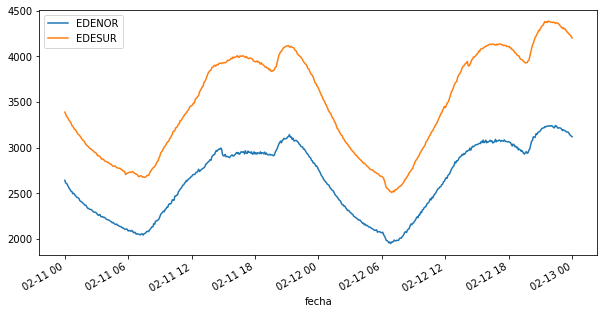

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').demAyer.plot(label=region2str[region])
    
plt.legend(loc='best')

In [44]:
cortes_df = pd.DataFrame(cortes)
cortes_df['usuarios afectados'] = cortes_df['usuarios afectados'].apply(int)
cortes_df['region'] = cortes_df.empresa.apply(lambda e: 1077 if e == 'EDESUR S.A.' else 1078)


In [118]:
import folium
from folium.plugins import HeatMap

# Create a base map using OpenStreetMap

m = folium.Map(location=[cortes_df.latitud.median(), cortes_df.longitud.median()], zoom_start=12)

# Sample data points (replace with your own data)
# data_points = [(latitude1, longitude1), (latitude2, longitude2), ...]
data_points = []
for doc in cortes_df.groupby(['latitud', 'longitud']):
    data_points.append((doc['latitud'], doc['longitud'], int(doc['usuarios afectados'])))

# Add a heatmap layer
HeatMap(data_points, radius=20).add_to(m)

# OR
m

In [47]:
clima_df = pd.DataFrame(clima)
clima_df['date_hour'] = clima_df.datetime.apply(lambda x: x.replace(minute=0))
clima_df['temperatura'] = clima_df['temperatura'].astype('int')

In [62]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,01:20,41164,1969,01n,Cielo Claro,26,2024-02-11 01:20:00,2024-02-11 01:00:00
1,01:25,41164,1969,01n,Cielo Claro,26,2024-02-11 01:25:00,2024-02-11 01:00:00
2,01:30,38574,1969,01n,Cielo Claro,26,2024-02-11 01:30:00,2024-02-11 01:00:00
3,01:35,38574,1969,01n,Cielo Claro,25,2024-02-11 01:35:00,2024-02-11 01:00:00
4,01:40,38574,1969,01n,Cielo Claro,25,2024-02-11 01:40:00,2024-02-11 01:00:00


In [95]:
clima_df_hour = (
    clima_df.groupby('date_hour')
            .agg({'estado_cielo': pd.Series.mode, 'ufs_edesur': 'mean', 
                  'ufs_edenor': 'mean', 'temperatura': 'mean'})
           .reset_index()
)

In [96]:
demanda_df['date_hour'] = demanda_df.fecha.apply(lambda x: x.replace(minute=0))
demanda_df_hour = (
    demanda_df.groupby(['date_hour', 'region'])
            .agg({'demHoy': 'mean', 'demAyer': 'mean', 'demSemanaAnt': 'mean'})
            .reset_index()
)

In [104]:
merged = (
    cortes_df.merge(clima_df_hour, left_on='date_hour', right_on='date_hour')
             .merge(demanda_df_hour, left_on=('date_hour', 'region'), right_on=('date_hour', 'region'))
)

In [105]:
len(cortes_df), len(clima_df), len(merged)

(9926, 7488, 9926)

In [107]:
pd.options.display.max_columns = 1000

In [108]:
merged.head()

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region,estado_cielo,ufs_edesur,ufs_edenor,temperatura,demHoy,demAyer,demSemanaAnt
0,-34.608568,-58.385937,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,SAN NICOLAS,POZOS,R:023-1-14/023-1-14,7,2024-02-11 02:09,2024-02-11 01:00:00,1077,Cielo Claro,39319.685714,1973.457143,25.571429,3296.666667,3121.75,3201.083333
1,-34.608596,-58.386360,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,SAN NICOLAS,POZOS,R:023-1-14/023-1-14,17,2024-02-11 02:09,2024-02-11 01:00:00,1077,Cielo Claro,39319.685714,1973.457143,25.571429,3296.666667,3121.75,3201.083333
2,-34.608583,-58.386164,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,SAN NICOLAS,POZOS,R:023-1-14/023-1-14,281,2024-02-11 02:09,2024-02-11 01:00:00,1077,Cielo Claro,39319.685714,1973.457143,25.571429,3296.666667,3121.75,3201.083333
3,-34.609070,-58.387526,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,MONSERRAT,POZOS,R:023-1-14/023-1-14,215,2024-02-11 02:09,2024-02-11 01:00:00,1077,Cielo Claro,39319.685714,1973.457143,25.571429,3296.666667,3121.75,3201.083333
4,-34.606940,-58.371768,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,SAN NICOLAS,RIVADAVIA,R:022-1-15/022-1-15,13,2024-02-11 06:52,2024-02-11 01:00:00,1077,Cielo Claro,39319.685714,1973.457143,25.571429,3296.666667,3121.75,3201.083333


# Preguntas

1) Sube la demanda cuando aumenta la temperatura?

2) Cuales son las zonas con mas demanda (con la data que tenemos no la podemos contestar)

3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?

4) El estado del cielo correlaciona con la demanda y con los cortes?

5) Hay algun horario de mayor cantidad de cortes?

6) Cuales son las zonas con mas usuarios afectados? 


### 1) Sube la demanda cuando aumenta la temperatura?


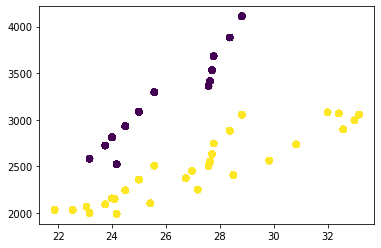

In [117]:
plt.scatter(merged.temperatura, merged.demHoy, c=merged.region)

### 3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?


In [124]:
cortes_df['partido_localidad'] = cortes_df.partido + "/" + cortes_df.localidad

In [126]:
cortes_df.partido_localidad.value_counts().head(5)

TIGRE/DELTA 1RA SECCION (TI)         1267
CAPITAL RP/CABALLITO RP               985
FLORENCIO VARELA/FLORENCIO VARELA     591
CAPITAL RP/PARQUE CHACABUCO           480
CAPITAL GP/CABALLITO GP               418
Name: partido_localidad, dtype: int64

### 4) El estado del cielo correlaciona con la demanda y con los cortes?


In [138]:
import numpy as np

[e for e in dir(np) if 'std' in e]

['nanstd', 'std']

In [141]:
clima_df.estado_cielo.value_counts()

Cielo Claro                     4038
Algo De Nubes                   1295
Nubes Dispersas                  936
Muy Nuboso                       801
Lluvia Ligera                    125
Lluvia Moderada                  124
Nubes                             56
Tormenta Con Lluvia Ligera        46
Tormenta Con Lluvia               46
Lluvia De Gran Intensidad         13
Tormenta Con Lluvia Intensa        8
Name: estado_cielo, dtype: int64

In [140]:
merged.estado_cielo.value_counts()
(
    merged.groupby('estado_cielo')
          .agg({'region': 'count', 'demHoy': 'mean'})
          .rename(columns=dict(region='cortes'))
          .sort_values('cortes', ascending=False)
)

,cortes,demHoy
estado_cielo,,
Cielo Claro,4262,2681.181605
Algo De Nubes,2061,2794.658400
Nubes Dispersas,1090,3074.476250
Lluvia Ligera,694,2258.887097
Muy Nuboso,598,3449.093645
Tormenta Con Lluvia Ligera,352,2068.166667
Tormenta Con Lluvia,313,2032.583333
Lluvia De Gran Intensidad,297,2031.750000
Lluvia Moderada,259,NaN


In [109]:
plt.scatter(merged)

<module 'matplotlib.pyplot' from '/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
demanda_df, cortes_df, clima_df

In [105]:
cortes_df.groupby('alimentador').latitud.nunique()

alimentador
N:                                           76
N:089-1-14/089-1-14                           1
N:SAN JUSTO/164-TR1/164-5518                  1
R:                                           97
R:020-4-45/020-4-45                           1
R:022-1-15/022-1-15                           1
R:023-1-14/023-1-14                           4
R:073-4-46/073-4-46                           1
R:077-3-34/077-3-34                          12
R:079-5-54/079-5-54                           5
R:089-1-16/089-1-16                           1
R:113-1-17/113-1-17                           8
R:122-4-41/122-4-41                           5
R:122-4-43/122-4-43                          12
R:122-4-45/122-4-45                           2
R:122-4-47/122-4-47                           8
R:143-3-36/143-3-36                           3
R:147-2-22/147-2-22                           1
R:172-2-26/172-2-26                           6
R:179-2-22/179-2-22                           1
R:182-1-16/182-1-16         

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


In [90]:
cortes_df.groupby('alimentador').latitud.count().sort_values(ascending=False)

alimentador
: R:TIGRE/153-TR2/153-5526                     444
: R:                                           394
: N:                                           347
: R:077-3-34/077-3-34                          125
: R:172-2-26/172-2-26                           72
: R:MANZONE/257-TR1/257-5518                    54
: R:122-4-43/122-4-43                           54
: R:023-1-14/023-1-14                           48
: R:MATANZA/65-TR1/65-5517                      48
: R:113-1-17/113-1-17                           37
: R:143-3-36/143-3-36                           36
: R:122-4-41/122-4-41                           34
: R:PILAR/158-TR5/158-5483                      28
: R:MALVINAS/169-TR2/169-5542                   25
: R:RAMOS MEJIA/66-TR1/66-5515                  16
: R:DERQUI/260-TR2/260-5526                     16
: R:122-4-47/122-4-47                           16
: R:277-4-44/277-4-44/271-4-81                  14
: R:122-4-45/122-4-45                           13
: R:147-2-22/147-2-